---
# EDA & Feature Extraction of the Complete Dataset
---

In this notebook, the main aim was to study the dataset with exploratory data analysis, combined with the feature extraction phase for the complete dataset.


## Libraries

In [45]:
import os 
import sys
import json 

from   random                    import sample
from   datetime                  import date

import pandas            as pd
import numpy             as np 
import matplotlib.pyplot as plt  
import seaborn           as sns
from   matplotlib.legend_handler import HandlerTuple

from   scipy.io                  import wavfile
from   python_speech_features    import mfcc, logfbank
import wave 
import librosa 

import cProfile    
from   tqdm                      import tqdm
from   IPython                   import display

In [2]:
sys.path.append('../src/features')
import feature_utils   as fs

sys.path.append('../src/data')
import data_utils      as ds
import constants

sys.path.append('../src/models')
import training_utils  as ts 

## Graphic Settings

In [3]:
def set_dark_theme(figsize=(8, 8),
                   dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [4]:
set_dark_theme()

## Common Filepaths between reduced and complete data

In [5]:
# Destination Path of the extracted .json file
JSON_PATH = "../data/processed/"

# Destination Path of .npy file
BINARIES_PATH = "../data/binaries/"

# Data Documentation path
DATA_DOCUMENTATION_PATH = "../data/raw/data_documentation/"

# Setting the default sample rate of 1 second file for the librosa library§
SAMPLES_TO_CONSIDER = 16000 

---
# Complete Dataset 
---

## Paths

In [6]:
# Defining Filepaths 

# N.B. The way the mfcc_feature_extraction function is defined assumes that the data folder 
# should contain only the sub-folders of labeled wav files 
COMPLETE_DATASET_PATH = "../data/raw/dataset_v2_complete/"

# name of the .json file 
COMPLETE_JSON_NAME = "mfcc_v2_complete_f_2022-05-23.json" 

## Preliminary EDA phase

### Checking for audio files shorter than 1s 

In [7]:
%%time 
short_audio_samples, short_audio_distribution, audio_distribution, total_audio_files = ds.length_sanity_check(COMPLETE_DATASET_PATH, verbosity = 1)
display.clear_output(wait=True)

CPU times: total: 38.1 s
Wall time: 8min 3s


### Saving names of short audio samples in a .txt file

In [8]:
textfile = open("../documents/short_audio_filenames_complete.txt", "w")

for element in short_audio_samples:
    textfile.write(element + "\n")
    
textfile.close()

## Descriptive Statistics of compliant and non-compliant Data

#### Number of short files

In [9]:
f"{len(short_audio_samples)} of short audio samples"

'10435 of short audio samples'

#### Total number of files

In [10]:
f"{total_audio_files} total audio samples for all 35" 

'105830 total audio samples for all 35'

#### Fraction of short files

In [11]:
f"We got approximately {round(len(short_audio_samples)/total_audio_files*100,2)}% of short audio files"

'We got approximately 9.86% of short audio files'

#### Percentages of short samples per category

In [12]:
percentages_of_short_samples_per_category = {}

print("Category \t total files \t short files \t percentage of short files \n")

for category in short_audio_distribution.keys():     
    percentages_of_short_samples_per_category[category] = short_audio_distribution[category]/audio_distribution[category]*100    
    print(f"{category:15s} \t {audio_distribution[category]} \t\t {short_audio_distribution[category]} \t {percentages_of_short_samples_per_category[category]}\n")

Category 	 total files 	 short files 	 percentage of short files 

backward        	 1665 		 107 	 6.426426426426427

bed             	 2015 		 329 	 16.327543424317618

bird            	 2065 		 307 	 14.86682808716707

cat             	 2032 		 315 	 15.501968503937007

dog             	 2129 		 309 	 14.513856270549555

down            	 3918 		 338 	 8.626850433894845

eight           	 3788 		 359 	 9.477296726504752

five            	 4053 		 326 	 8.043424623735504

follow          	 1580 		 126 	 7.974683544303797

forward         	 1558 		 106 	 6.8035943517329915

four            	 3729 		 326 	 8.742290158219362

go              	 3881 		 403 	 10.383921669672764

happy           	 2055 		 290 	 14.111922141119221

house           	 2114 		 283 	 13.386944181646168

learn           	 1576 		 150 	 9.517766497461928

left            	 3802 		 300 	 7.890583903208838

marvin          	 2101 		 270 	 12.851023322227512

nine            	 3935 		 307 	 7.801778907242694

no     

#### Display Absolute Frequencies of Categories

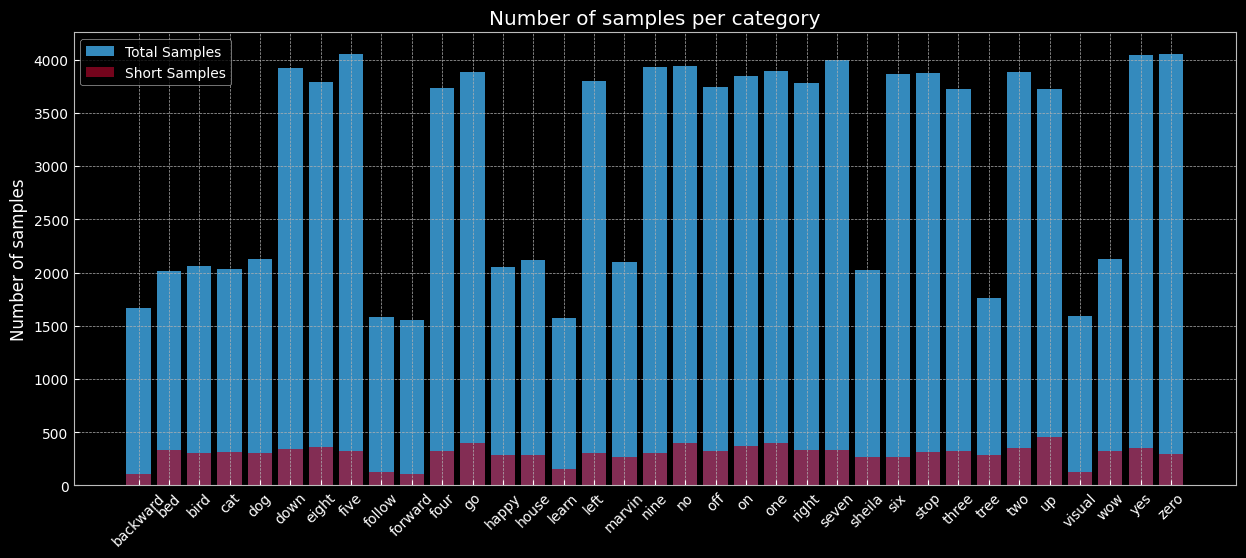

In [13]:
plt.figure(figsize = (15,6))

plt.bar(range(len( list(audio_distribution.keys()))) , list(audio_distribution.values()), label = "Total Samples")

plt.title("Number of samples per category")
plt.xticks(range(len(list(audio_distribution.keys()))), audio_distribution.keys(), rotation = 45)
plt.ylabel("Number of samples")
plt.bar(range(len( list(short_audio_distribution.keys()))) , list(short_audio_distribution.values()), label = "Short Samples", alpha = 0.7)

plt.legend()
plt.show()

The distribution of the audio files is un-even. Particular abudance for the classes from the v1 of the dataset. The distribution of short audio files seems to be proportional to the compliant ones. This makes us hypothesize that it may be present a systematic error in the data acquisition phase. 

#### Sample Mean, Median and Standard Deviation of # of short samples 

In [14]:
data_items = short_audio_distribution.items()
data_list = list(data_items)
short_audio_distribution_df = pd.DataFrame(data_list, columns = ["categories","absolute_frequency"])

In [15]:
short_audio_distribution_df.describe().T

count        mean        std    min    25%    50%    75%  \
absolute_frequency   35.0  299.142857  83.864787  106.0  285.0  315.0  334.5   

                      max  
absolute_frequency  455.0

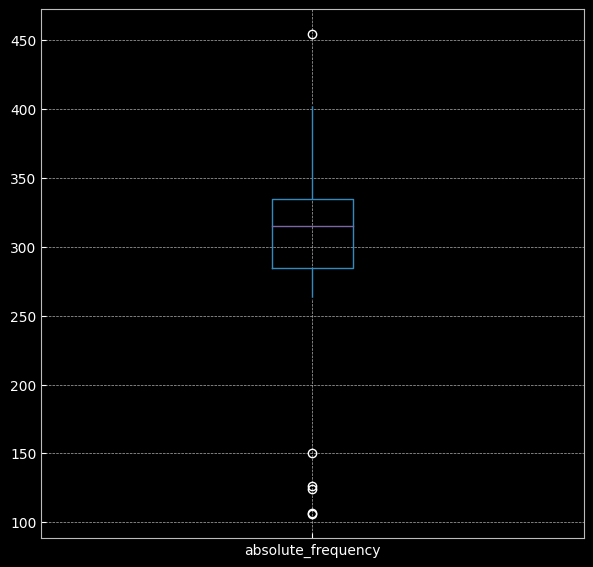

In [16]:
short_audio_distribution_df.boxplot(figsize = (7,7));

## Analysis of audio quality 

Here we do extract 10 random audio traces per category from the training data, excluding files that are shorter than 1s. 

In [17]:
demo_sample_audio, demo_sample_names  = ds.extract_random_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                documentation_filename = "../documents/audio_filenames_train.txt",
                                                                file_amount = 10,
                                                                save = False)

Executed on 2022-06-10


The actual classes are ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']



Insert one of the 35 classes:  backward


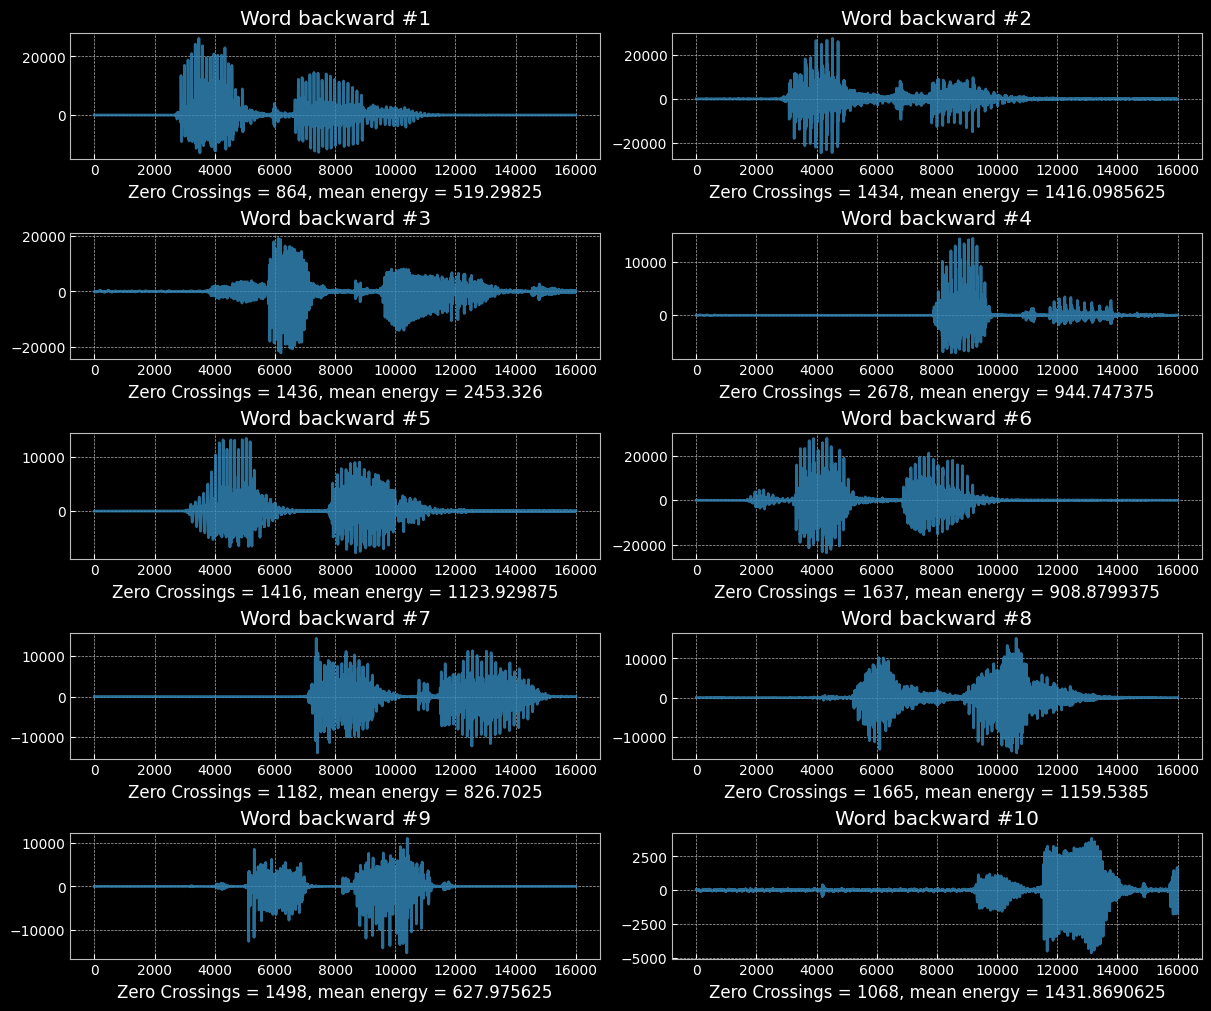

In [18]:
fig, axs = plt.subplots(5, 2, figsize = (12,10), constrained_layout = True)
counter = 0

print(f"The actual classes are {list(constants.labels_35_classes.keys())}\n")

category = input("Insert one of the 35 classes: ").lower() 

for i in range(5):
    
    for j in range(2):
        
        # Raw Signal
        file = demo_sample_audio[category][counter]
        axs[i,j].plot(file, alpha = 0.8)
        axs[i,j].set_title(f"Word {category} #{counter+1}")
        
        # Zero Crossings
        zc_value = librosa.zero_crossings(file)
        zc_feature = np.sum(zc_value)
        
        axs[i,j].set(xlabel=f"Zero Crossings = {zc_feature}, mean energy = {fs.energy(file, mean = True)}")
        counter += 1

In [19]:
display.Audio(demo_sample_audio[category][1], rate = 16000)

### Importing all (compliant) training audio data 

In [20]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    compliant_audio_train, compliant_audio_names_train = ds.extract_random_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                            documentation_filename = "../documents/audio_filenames_train.txt" , 
                                                                            file_amount = 100, 
                                                                            save = False)
    
else:
    
    compliant_audio_train, compliant_audio_names_train = ds.extract_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                     documentation_filename = "../documents/audio_filenames_train.txt",
                                                                     save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


### Importing all (compliant) validation audio data 

In [21]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    compliant_audio_valid, compliant_audio_names_valid = ds.extract_random_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                            documentation_filename = "../documents/audio_filenames_valid.txt" , 
                                                                            file_amount = 100, 
                                                                            save = False)
    
else:
    
    compliant_audio_valid, compliant_audio_names_valid = ds.extract_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                     documentation_filename = "../documents/audio_filenames_valid.txt",
                                                                     save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


### Importing all (compliant) test audio data 

In [22]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    compliant_audio_test, compliant_audio_names_test = ds.extract_random_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                            documentation_filename = "../documents/audio_filenames_test.txt" , 
                                                                            file_amount = 100, 
                                                                            save = False)
    
else:
    
    compliant_audio_test, compliant_audio_names_test = ds.extract_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                     documentation_filename = "../documents/audio_filenames_test.txt",
                                                                     save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


### Importing all (non-compliant) audio data 

In [23]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    short_audio, short_audio_names = ds.extract_random_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                    documentation_filename = "../documents/short_audio_filenames_complete.txt",
                                                                    file_amount = 100,
                                                                    save = False)
    
else:
      
    short_audio, short_audio_names = ds.extract_audio(dataset_path = COMPLETE_DATASET_PATH,
                                                             documentation_filename = "../documents/short_audio_filenames_complete.txt",
                                                             save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


## Audio features for quality check

###  Zero-Crossings & Zero Crossing Rate
The [zero crossing rate](https://en.wikipedia.org/wiki/Zero-crossing_rate) indicates the number of times that a signal crosses the horizontal axis in time. Also the zero crossings are extracted.

In [24]:
%%time 
#Train
zc_feature_train, zcr_feature_train = fs.zero_crossings(compliant_audio_train)
# Valid
zc_feature_valid, zcr_feature_valid = fs.zero_crossings(compliant_audio_valid)
#Test
zc_feature_test, zcr_feature_test   = fs.zero_crossings(compliant_audio_test)
# non-compliant audio files
zc_feature_short, zcr_feature_short = fs.zero_crossings(short_audio)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 1min 15s
Wall time: 1min 16s


#### Comparing Zero Crossings Distributions across Categories - Empirical Probability Distribution of train compliant audio files and non-compliant 

We recall that zero crossing is a scalar value per each sample. 

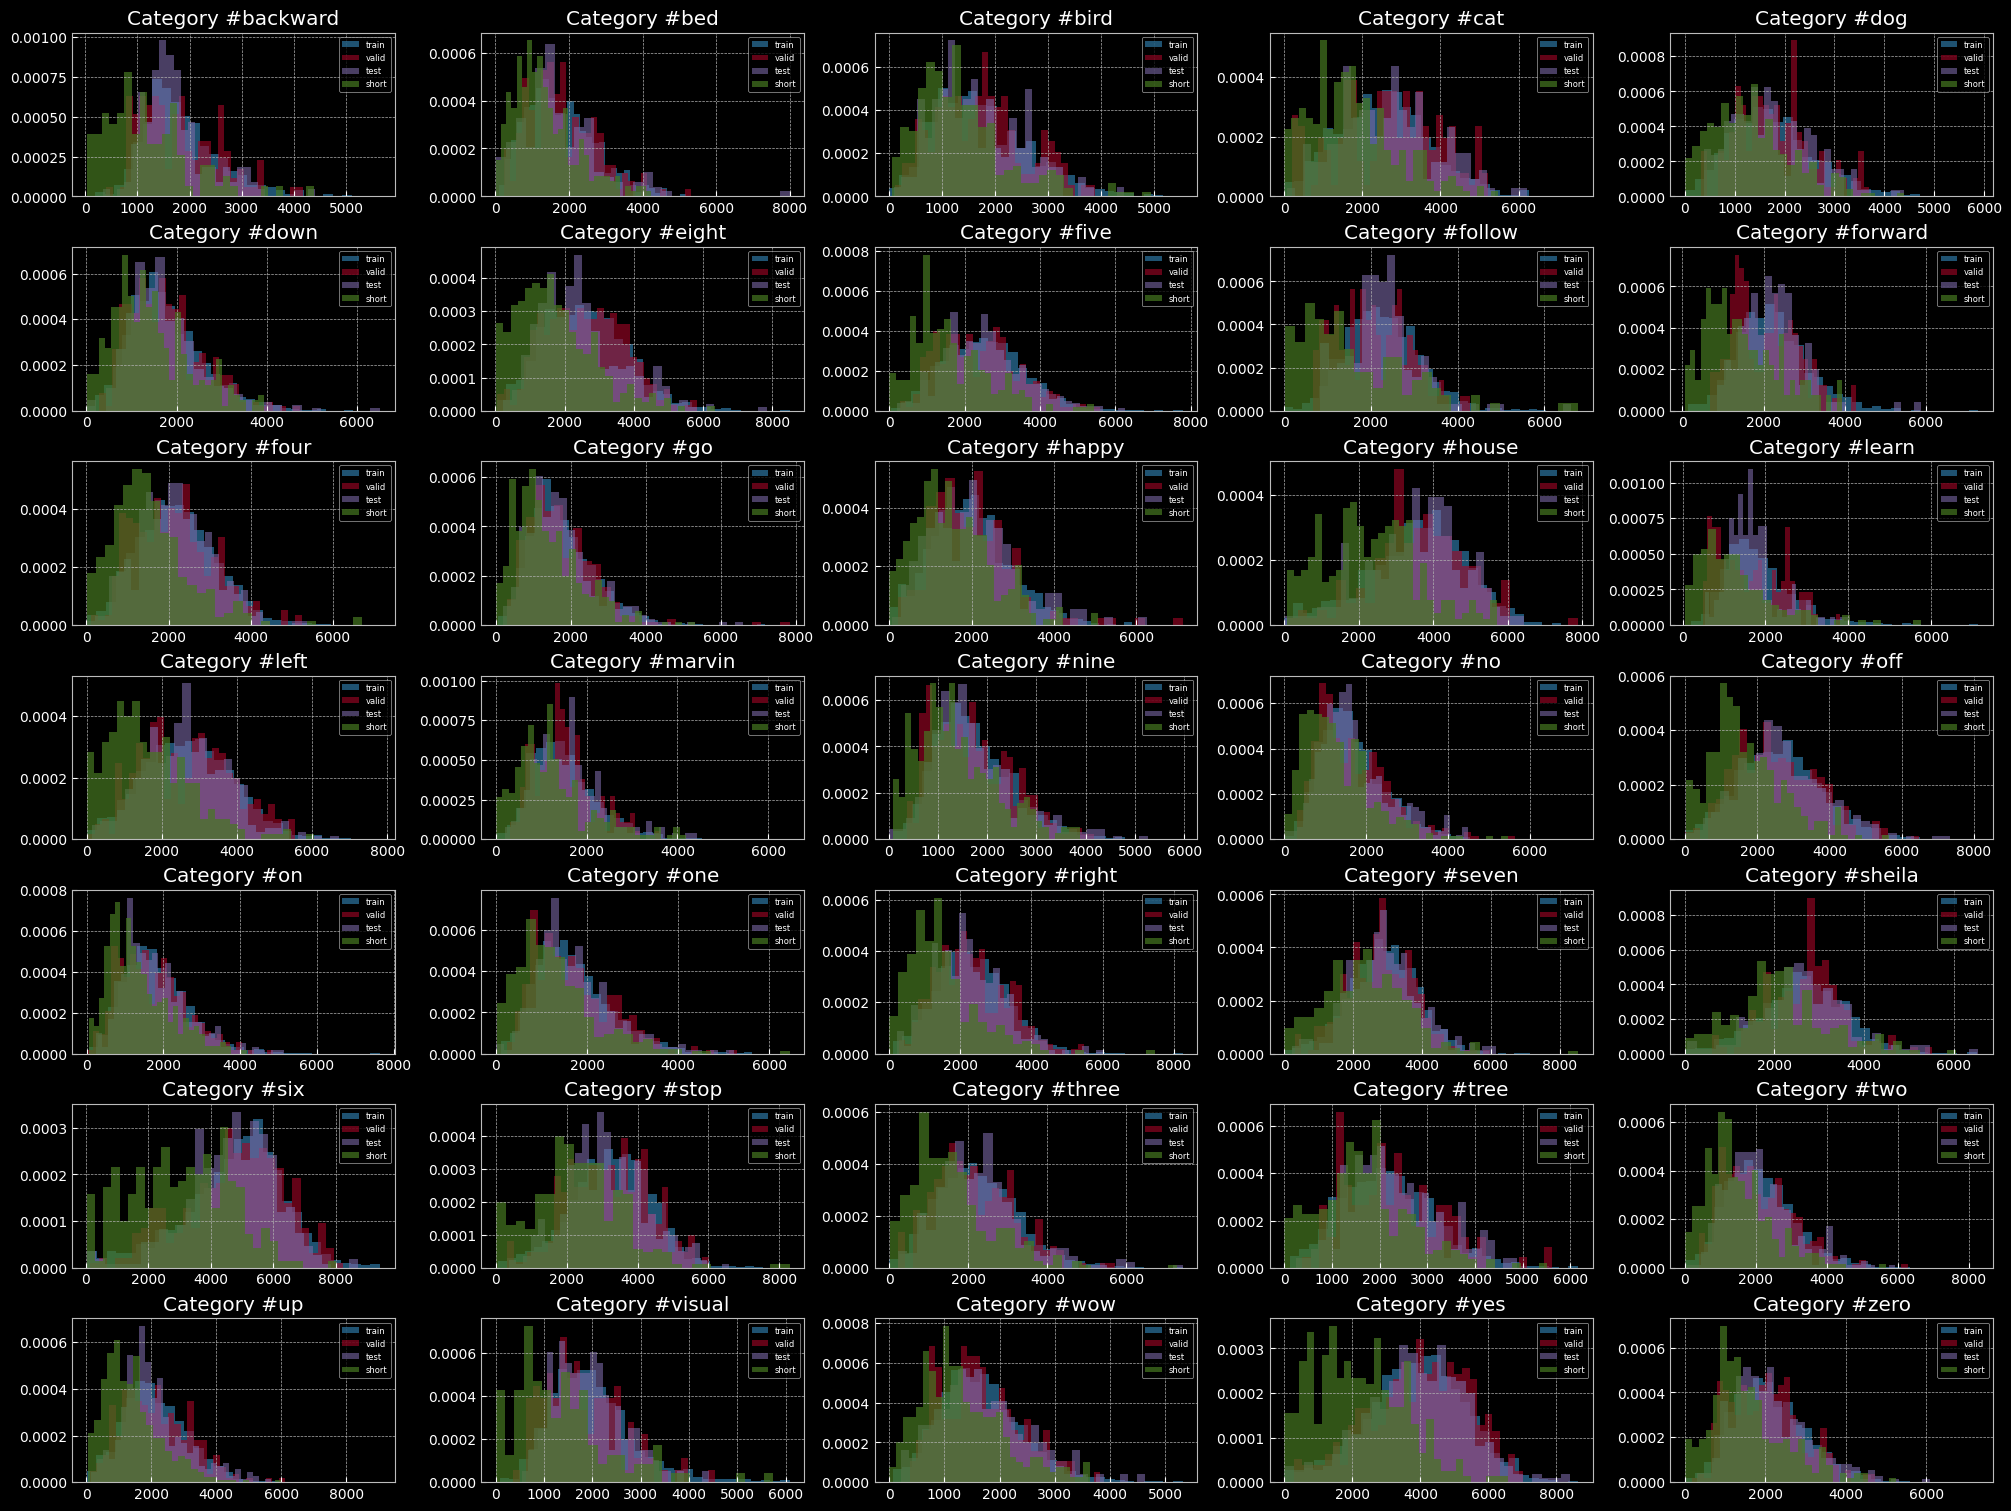

In [25]:
fig, axs = plt.subplots(7, 5, figsize = (20,15), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(7):
    
    for j in range(5):
        
        
        axs[i,j].hist(zc_feature_train[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(zc_feature_valid[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(zc_feature_test[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(zc_feature_short[categories[counter]], bins = 30, alpha=0.7, density = True, label = "short")

        axs[i,j].legend(loc = "upper right", prop={'size': 6})
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

#### Plot specific Categories

Available Categories 
 ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Insert a category, if not press enter seven
Insert a category, if not press enter 


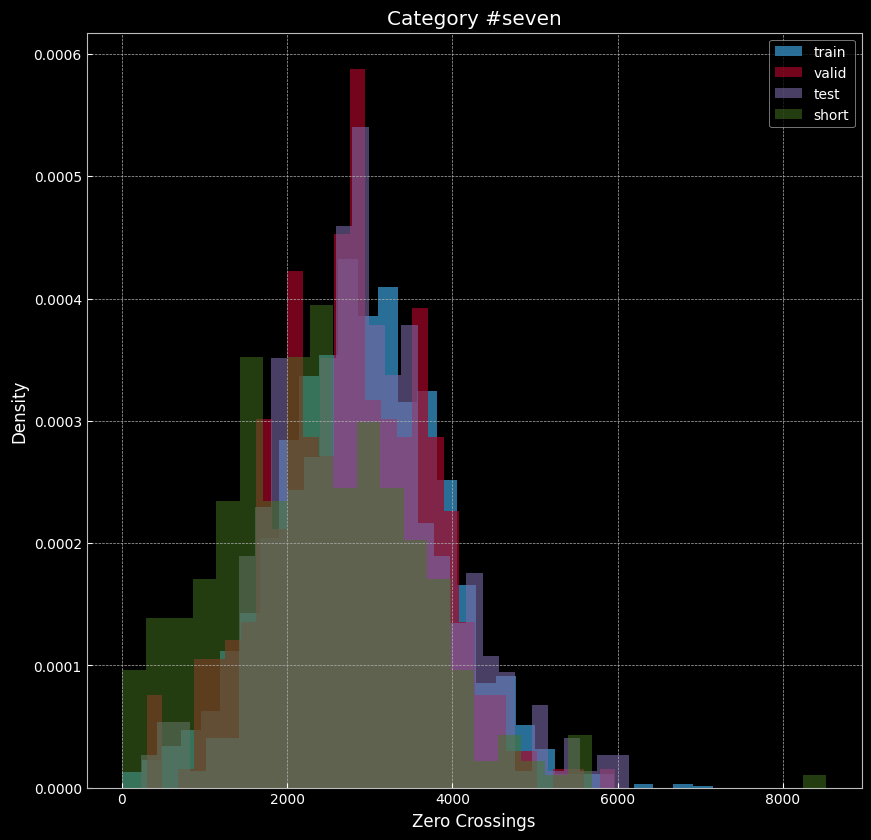

In [26]:
print("===========================================================================================")
all_classes = list(constants.labels_35_classes.keys())
print(f"Available Categories \n {all_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in all_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(zc_feature_train[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(zc_feature_valid[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(zc_feature_test[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(zc_feature_short[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category}")
    plt.xlabel(xlabel = "Zero Crossings")
    plt.ylabel(ylabel = "Density")
    
    category = input("Insert a category, if not press enter")

#### Zero Crossing Rate 

This is the evolution over time of the zero crossings value, over a window of 512 samples (*frame size*) and an overlap of 256 samples. Here we display the zero crossing rate for just a single audio. 

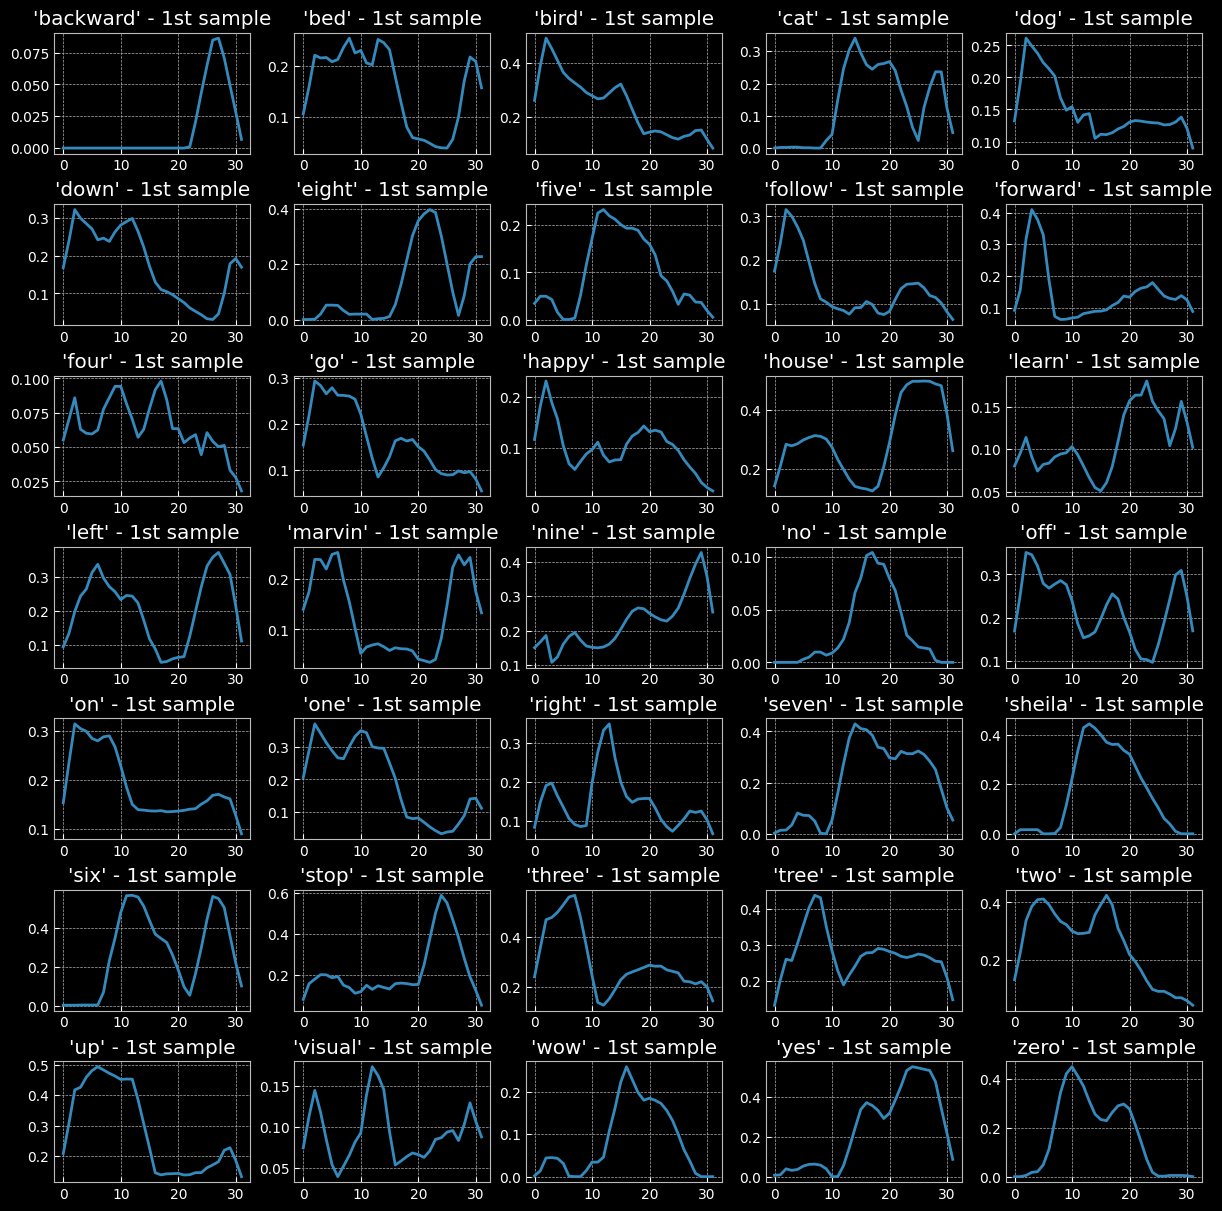

In [27]:
fig, axs = plt.subplots(7, 5, figsize = (12,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(7):
    for j in range(5):
        axs[i,j].plot(zcr_feature_train[categories[counter]][0])
        axs[i,j].set_title(f"'{categories[counter]}' - 1st sample")
        # axs[i,j].xlabel("Spectral Centroid")
        counter += 1

As a first thing we can notice how this feature seems to reflect the increase in frequency fo

### Spectral Centroid


The [spectral centroid](https://en.wikipedia.org/wiki/Spectral_centroid) is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound. It is sometimes called center of spectral mass.
It is calculated as the weighted mean of the frequencies present in the signal, determined using a Fourier transform, with their magnitudes as the weights
$$centroid = \frac{\sum_{n=0}^{N-1}f(n)x(n)}{\sum_{n=0}^{N-1}x(n)}$$
where x(n) represents the weighted frequency value, or magnitude, of bin number n, and f(n) represents the center frequency of that bin.

From [librosa's documentation](http://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html):

"Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.
More precisely, the centroid at frame $t$ is defined as:
$$centroid[t] = sum_k S[k, t] * freq[k] / (sum_j S[j, t])$$
where S is a magnitude spectrogram, and freq is the array of frequencies (e.g., FFT frequencies in Hz) of the rows of S."

In [28]:
spectral_centroid = {}

for category in compliant_audio_train.keys():

    spectral_centroid[category] = []

    for file in compliant_audio_train[category]:
        
        sc_value = librosa.feature.spectral_centroid(y = file.astype(np.float32), sr = 16000).T
        spectral_centroid[category] += [sc_value]

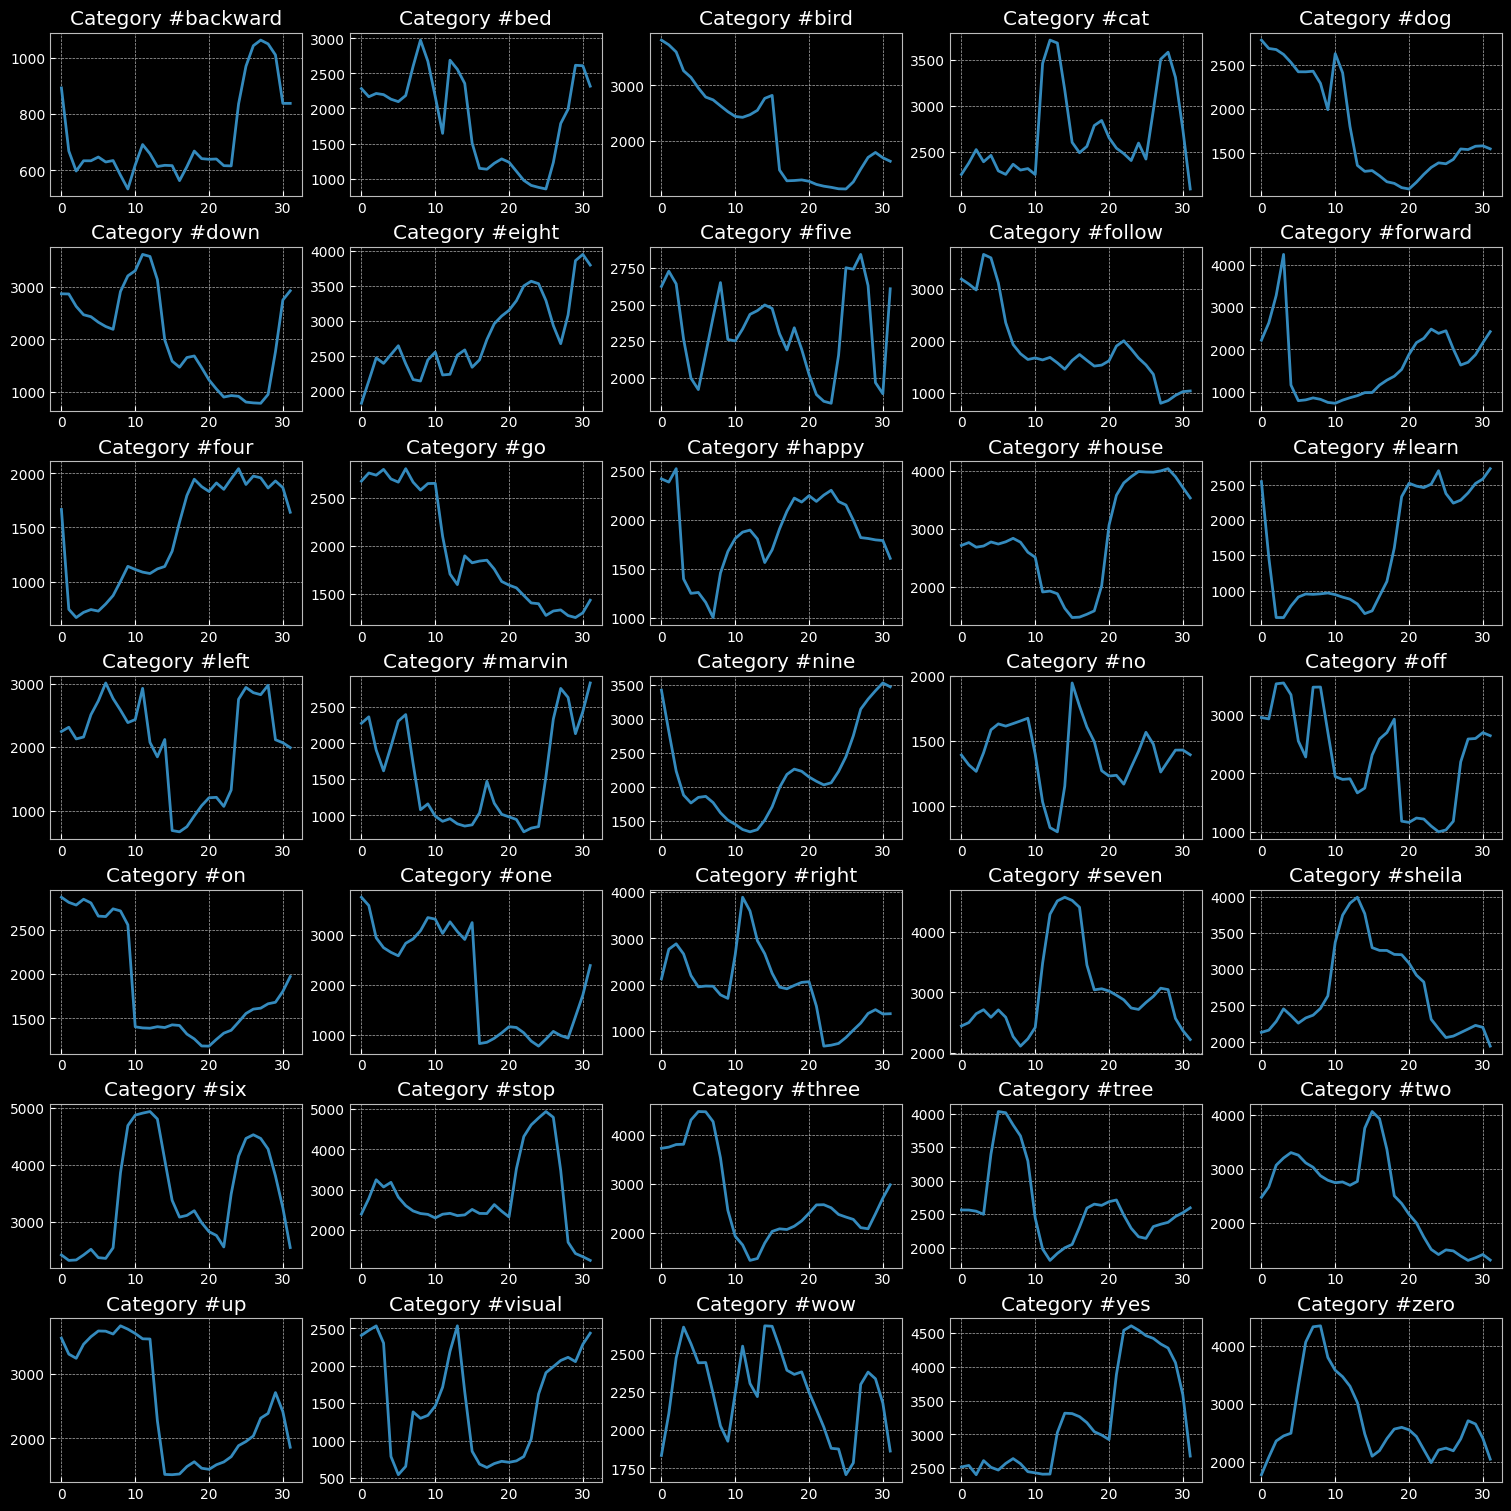

In [29]:
fig, axs = plt.subplots(7, 5, figsize = (15,15), constrained_layout = True)
counter, categories = 0, list(spectral_centroid.keys()) 

for i in range(7):
    for j in range(5):
        axs[i,j].plot(spectral_centroid[categories[counter]][0])
        axs[i,j].set_title(f"Category #{categories[counter]}")
        counter += 1

### Mean Energy 
The **energy** ([Wikipedia](https://en.wikipedia.org/wiki/Energy_(signal_processing%29))) of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The energy in a signal is defined as $ \sum_n \left| x(n) \right|^2 $. Mean energy is the energy of a signal divided by its length.

In [30]:
%%time 
#Train
energies_feature_train = fs.mean_energies(compliant_audio_train)
# Valid
energies_feature_valid = fs.mean_energies(compliant_audio_valid)
#Test
energies_feature_test  = fs.mean_energies(compliant_audio_test)
# non-compliant audio files
energies_feature_short = fs.mean_energies(short_audio)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 5.66 s
Wall time: 5.66 s


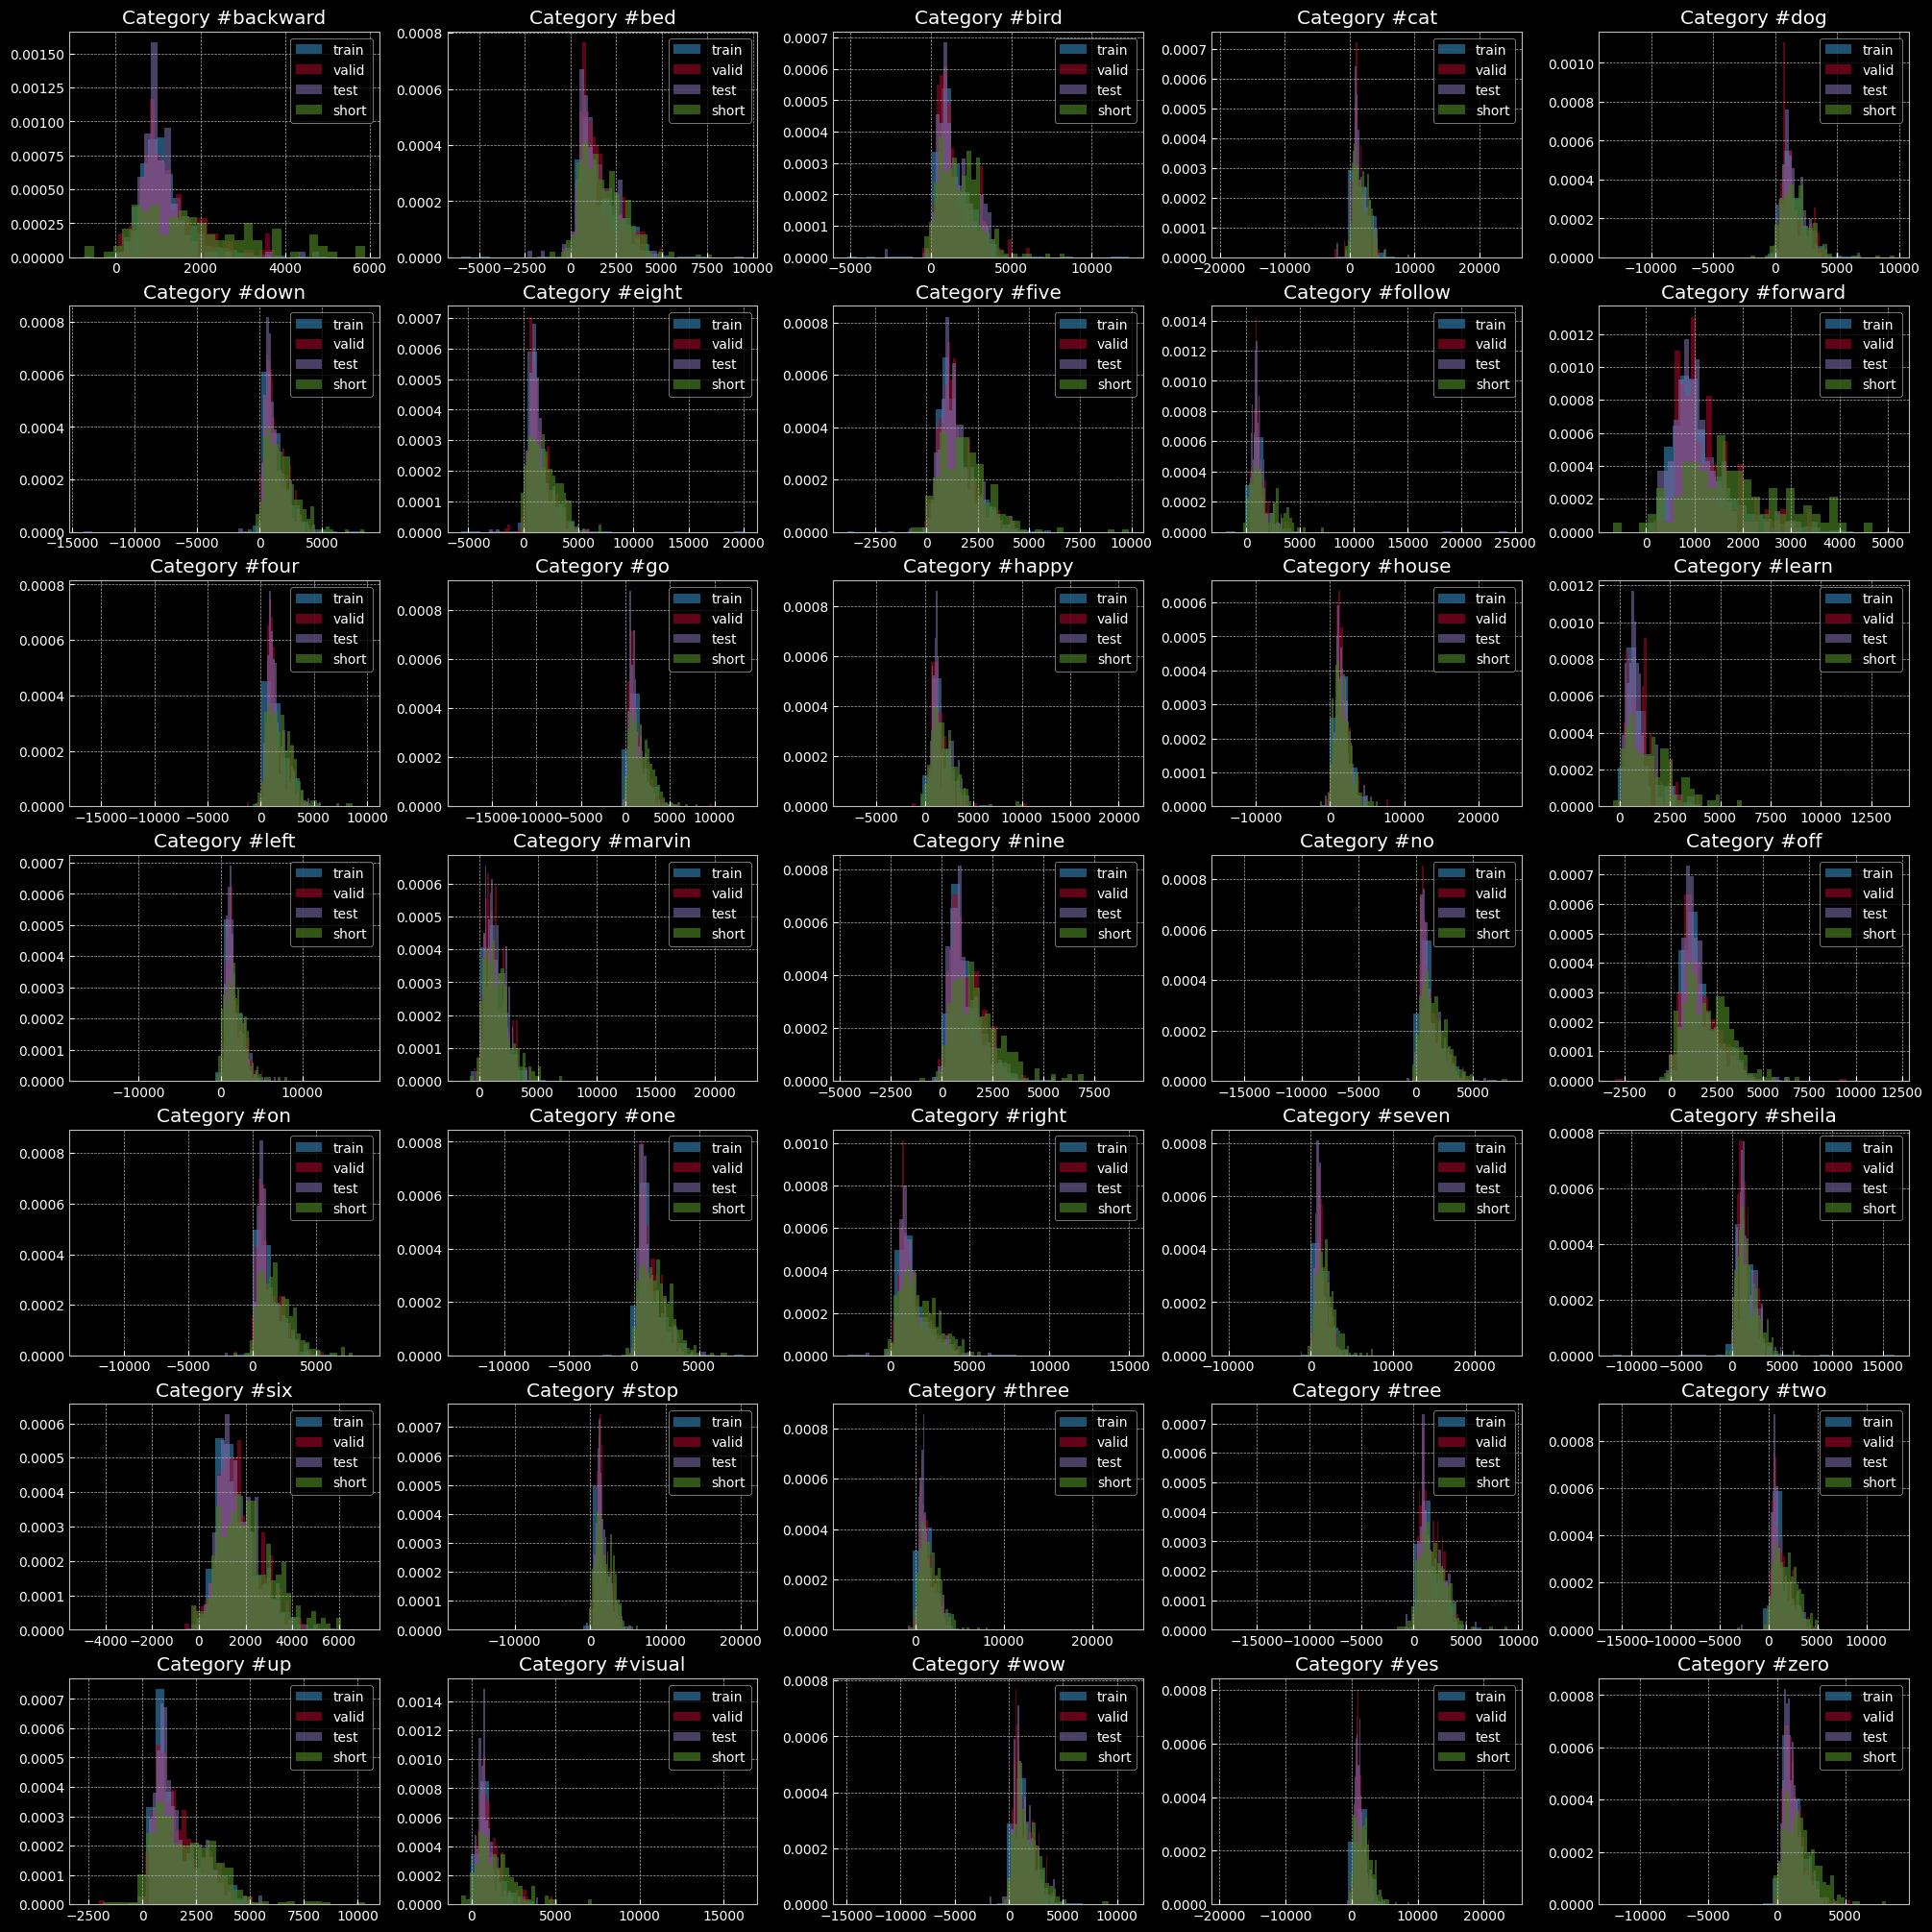

In [31]:
fig, axs = plt.subplots(7, 5, figsize = (20,20), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(7):
    for j in range(5):
        
        axs[i,j].hist(energies_feature_train[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(energies_feature_valid[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(energies_feature_test[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(energies_feature_short[categories[counter]], bins = 30, alpha=0.7, density = True, label = "short")

        axs[i,j].legend(loc = "upper right")
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

Available Categories 
 ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


Insert a category, if not press enter stop
Insert a category, if not press enter 


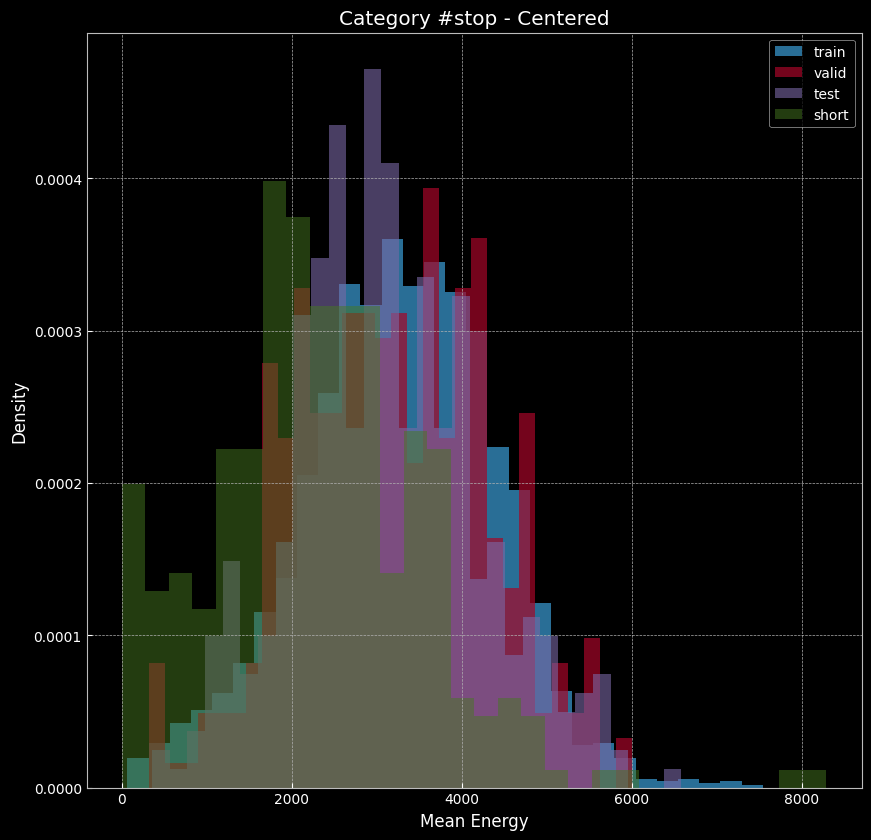

In [32]:
print("===========================================================================================")
all_classes = list(constants.labels_35_classes.keys())
print(f"Available Categories \n {reduced_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in all_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(zc_feature_train[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(zc_feature_valid[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(zc_feature_test[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(zc_feature_short[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category} - Centered")
    plt.xlabel(xlabel = "Mean Energy")
    plt.ylabel(ylabel = "Density")
    

    category = input("Insert a category, if not press enter")

## Finding human unclassifiable samples

To make such research we may do some consideration made on the preliminary analyses. 
This process could be time exhausting since to identify such files we may need a human being detect them. The alternative may rely on some temporal analysis' features, like the ones we considered before. 

Nonetheless, given a *signal* $x(n): n = 1, \dots, N$, the ones we want to use are: 
- *Length of the Signal* $\normalsize N$ 
- *Mean Energy* $\normalsize  \mathbf{\bar{E}}[x(n)] = \frac{\sum_{n=1}^{N}|x(n)|^2}{N}$  (the absolute value isn't necessary since we're not dealing with complex numbers here)
- *Scaled Zero Crossings* $\normalsize \operatorname{ZC}_{\text{scaled}}[x(n)] =  \frac{\sum_{n = 1}^{N - 1} \mathbf{1}_{\mathbf{R}_{<0}}(x(n)* x(n+1))}{N}$

To overcome some of the issues in the search of unuseful samples we shall center each signal.

### Centering

In [33]:
compliant_audio_train_centered, compliant_audio_valid_centered, compliant_audio_test_centered, short_audio_centered = {}, {}, {}, {} 

for category in compliant_audio_train.keys():
    
    # Training Data
    for file in compliant_audio_train[category]: 
        
        if category in compliant_audio_train_centered.keys():
            compliant_audio_train_centered[category] += [file-np.mean(file)]
        else: 
            compliant_audio_train_centered[category] = [file-np.mean(file)]
    # Validation Data 
    for file in compliant_audio_valid[category]: 
        
        if category in compliant_audio_valid_centered.keys():
            compliant_audio_valid_centered[category] += [file-np.mean(file)]
        else: 
            compliant_audio_valid_centered[category] = [file-np.mean(file)]
    # Test Data 
    for file in compliant_audio_train[category]: 
            
        if category in compliant_audio_test_centered.keys():
            compliant_audio_test_centered[category] += [file-np.mean(file)]
        else: 
            compliant_audio_test_centered[category] = [file-np.mean(file)]    
    # Short Data
    for file in short_audio[category]: 
        
        if category in short_audio_centered.keys():
            short_audio_centered[category] += [file-np.mean(file)]
        else: 
            short_audio_centered[category] = [file-np.mean(file)]        

### Scaled Zero Crossings on centered audio files

In [34]:
%%time 
#Train
zc_feature_train_centered = fs.zero_crossings(compliant_audio_train_centered,
                                              scaled = True,
                                              rate = False)
# Valid
zc_feature_valid_centered = fs.zero_crossings(compliant_audio_valid_centered, 
                                              scaled = True, 
                                              rate = False)
#Test
zc_feature_test_centered  = fs.zero_crossings(compliant_audio_test_centered,  
                                              scaled = True, 
                                              rate = False)
# non-compliant audio files
zc_feature_short_centered = fs.zero_crossings(short_audio_centered,
                                              scaled = True, 
                                              rate = False)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 54.2 s
Wall time: 1min 4s


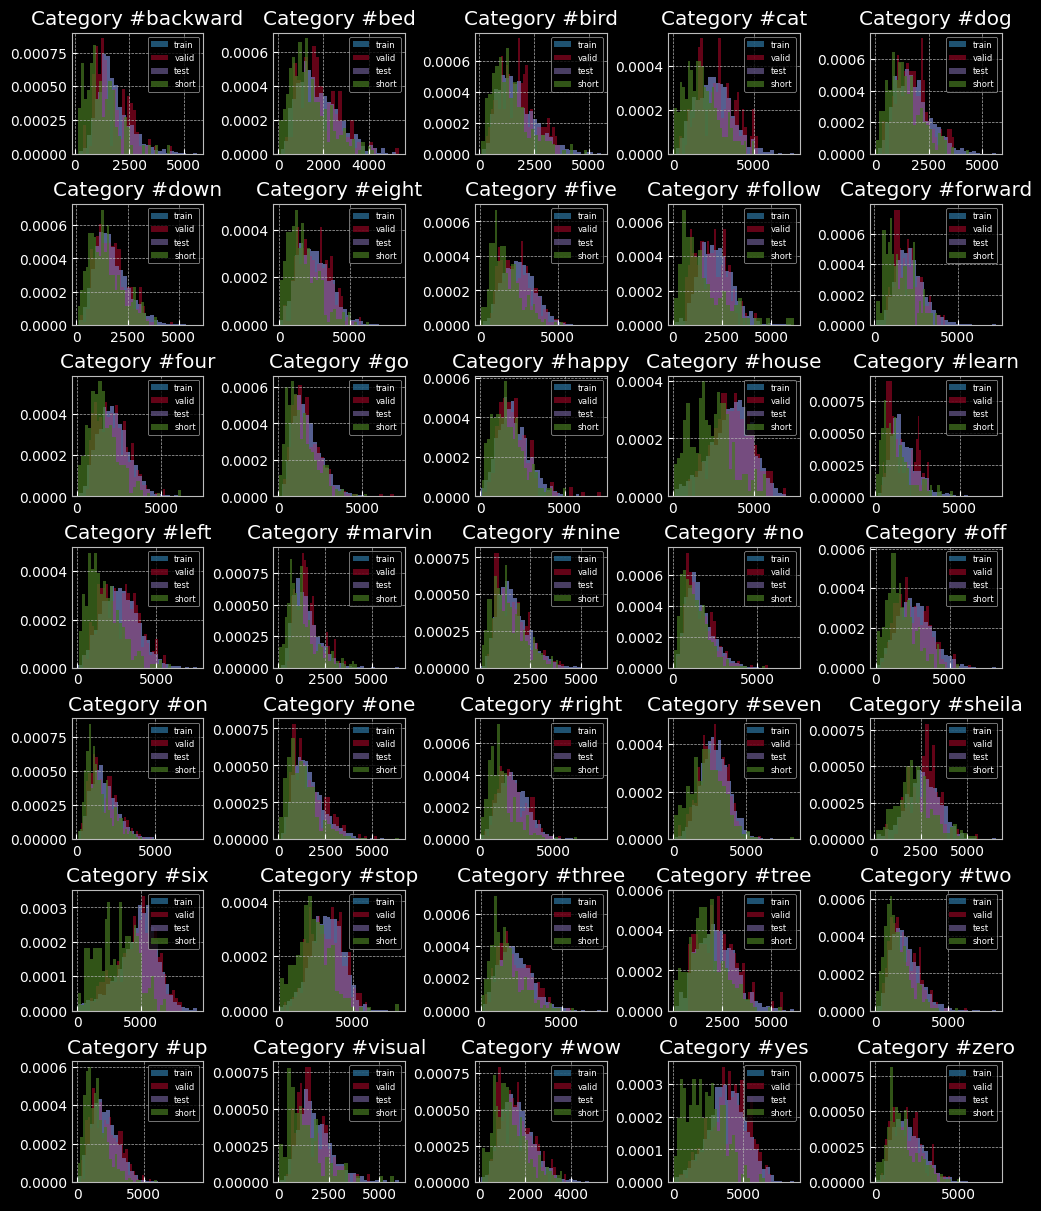

In [35]:
fig, axs = plt.subplots(7, 5, figsize = (10,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(7):
    
    for j in range(5):
        
        axs[i,j].hist(zc_feature_train_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(zc_feature_valid_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(zc_feature_test_centered[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(zc_feature_short_centered[categories[counter]], bins = 30, alpha=0.7, density = True, label = "short")

        axs[i,j].legend(loc = "upper right", prop={'size': 6})
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

Available Categories 
 ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Insert a category, if not press enter sheila
Insert a category, if not press enter 


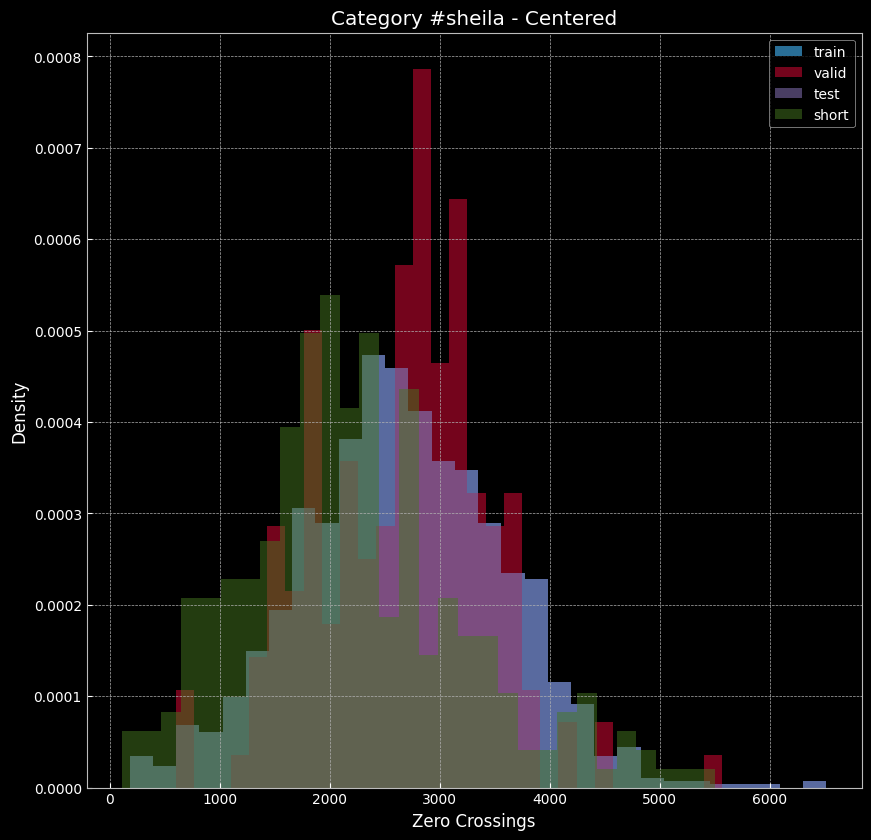

In [36]:
print("===========================================================================================")
all_classes = list(constants.labels_35_classes.keys())
print(f"Available Categories \n {all_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in all_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(zc_feature_train_centered[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(zc_feature_valid_centered[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(zc_feature_test_centered[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(zc_feature_short_centered[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category} - Centered")
    plt.xlabel(xlabel = "Zero Crossings")
    plt.ylabel(ylabel = "Density")
    
    
    category = input("Insert a category, if not press enter")

### Mean Energy of centered Audio files

In [40]:
%%time 
#Train
energies_feature_train_centered = fs.mean_energies(compliant_audio_train_centered)
# Valid
energies_feature_valid_centered = fs.mean_energies(compliant_audio_valid_centered)
#Test
energies_feature_test_centered   = fs.mean_energies(compliant_audio_test_centered)
# non-compliant audio files
energies_feature_short_centered = fs.mean_energies(short_audio_centered)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 6.92 s
Wall time: 6.93 s


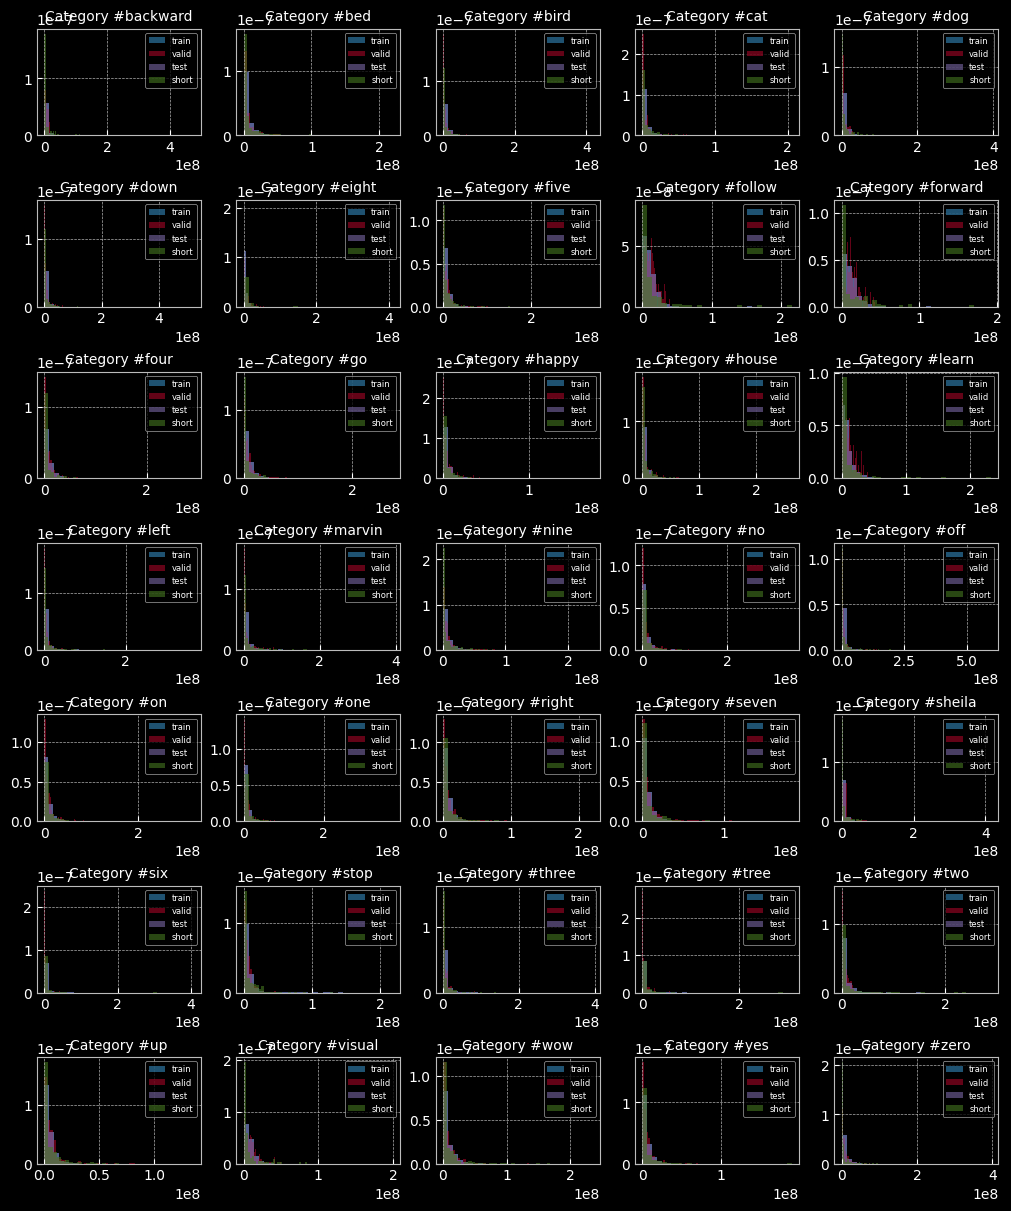

In [48]:
fig, axs = plt.subplots(7, 5, figsize = (10,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(7):
    for j in range(5):
        
        axs[i,j].hist(energies_feature_train_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(energies_feature_valid_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(energies_feature_test_centered[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(energies_feature_short_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "short")

        axs[i,j].legend(loc = "upper right", prop={'size': 6})
        axs[i,j].set_title(f"Category #{categories[counter]}", fontsize = 10)
        
        counter += 1

Available Categories 
 ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


Insert a category, if not press enter up
Insert a category, if not press enter 


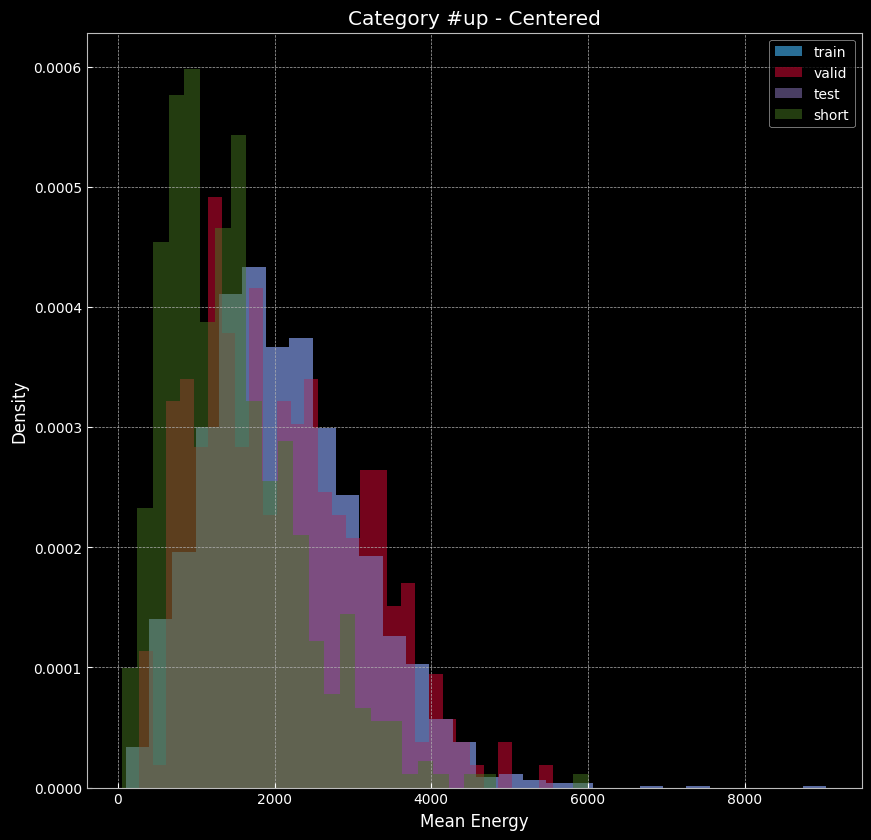

In [42]:
print("===========================================================================================")
all_classes = list(constants.labels_35_classes.keys())
print(f"Available Categories \n {all_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in all_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(zc_feature_train_centered[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(zc_feature_valid_centered[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(zc_feature_test_centered[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(zc_feature_short_centered[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category} - Centered")
    plt.xlabel(xlabel = "Mean Energy")
    plt.ylabel(ylabel = "Density")
    

    category = input("Insert a category, if not press enter")

### Distribution of $\normalsize \phi = (\mathbf{\bar{E}}[x(n)],  \operatorname{ZC}_{\text{scaled}}[x(n)])$



Would you prefer centered data features? y/n:   y


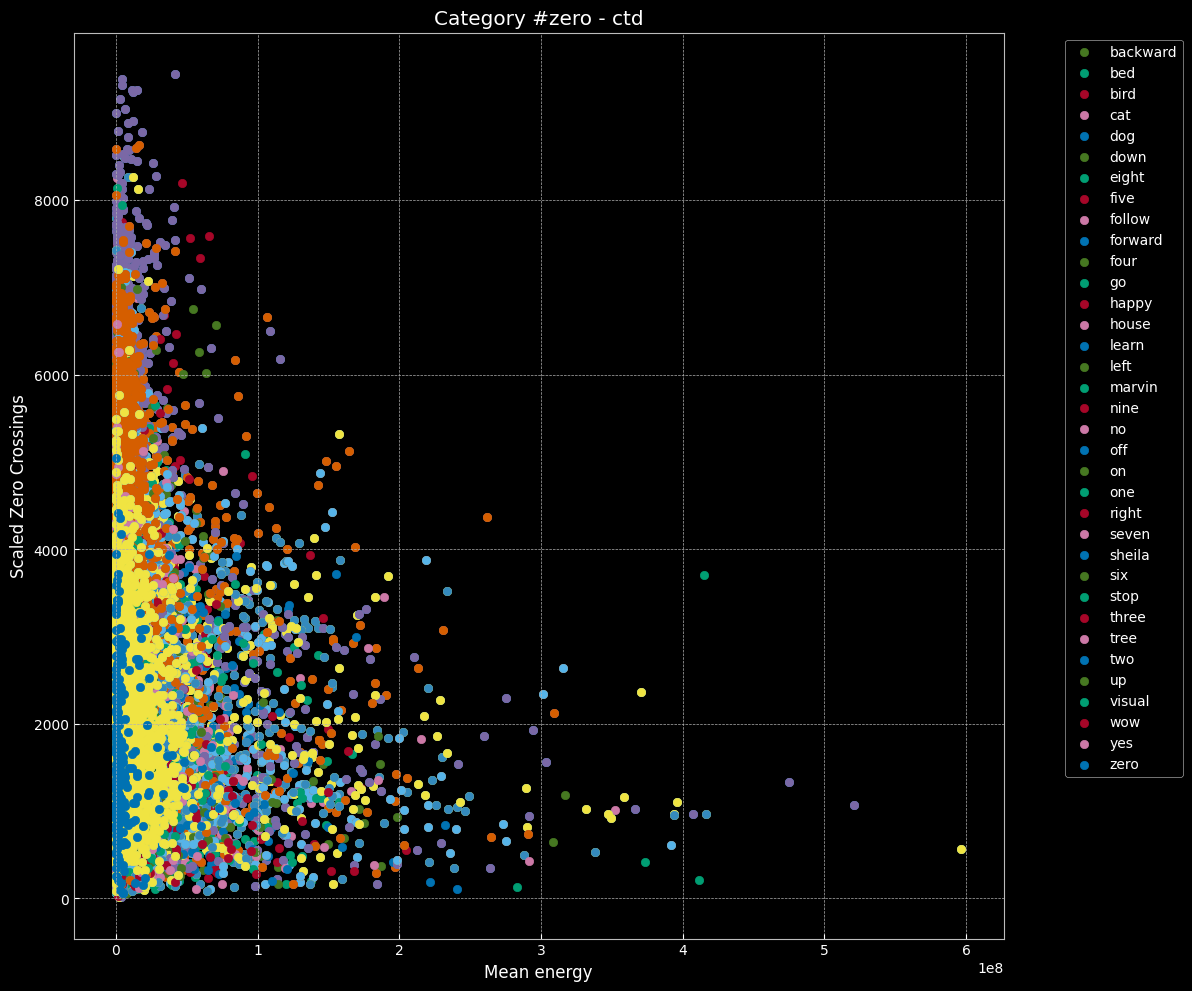

In [53]:
fig = plt.figure(figsize = (12,12))
centered =  input("Would you prefer centered data features? y/n:  ").lower() 



for category in all_classes: 
    
    if centered == "y":
        
        plt.scatter(energies_feature_train_centered[category], zc_feature_train_centered[category], label = f"{category}")
        plt.scatter(energies_feature_valid_centered[category], zc_feature_valid_centered[category], label = f"{category}")
        plt.scatter(energies_feature_test_centered[category],  zc_feature_test_centered[category], label = f"{category}")

        plt.scatter(energies_feature_short_centered[category], zc_feature_short_centered[category], label = f"{category}")
        
        plt.xlabel("Mean energy")
        plt.ylabel("Scaled Zero Crossings")
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        
        plt.legend(by_label.values(), by_label.keys(), loc = "upper right", bbox_to_anchor=(1.2, 1))
        plt.title(f"Category #{category} - ctd")
    
    else: 
        
        plt.scatter(energies_feature_train[category], zc_feature_train[category], label = f"{category}")
        plt.scatter(energies_feature_valid[category], zc_feature_valid[category], label = f"{category}")
        plt.scatter(energies_feature_test[category],  zc_feature_test[category], label = f"{category}")

        plt.scatter(energies_feature_short[category], zc_feature_short[category], label = f"{category}")
        
        plt.xlabel("Mean energy")
        plt.ylabel("Zero Crossings")

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        
        plt.legend(by_label.values(), by_label.keys(), loc = "upper right", bbox_to_anchor=(1.2, 1))
        plt.title(f"Category #{category} - raw")

### Adding random noise to the ones that didn't surpass the sanity check -- STILL TO DO

In [ ]:
# ds.add_random_noise(REDUCED_DATASET_PATH)

## MFCCs - Feature Extraction 

In this passage we extract the *Mel Cepstral Coefficients Feature* from the audio tracks. This has a twofold explanation. First, our dataset is quite huge (2,3 GiB) the preprocessing phase should be done beforehead to reduce time and computational resources. In particular, with the following function, we proceed by extracting the MFCC representation of our audio data, in a `.json` format.

Secondly, MFCCs capture timbral/textural aspects of sound. So extracting properties such the latter from audio in a visual way allows a great variety of applications (genre recognition, music instrument recognition, ...), given by the expressiveness of this feature representation of the raw data. 

Here below we specify the dataset's path and the destination path of the associated `.json` file. Another constant is the default sample frequency used by the librosa library. 

### Feature Extraction excluding short audio files 

In [ ]:
short_audio_samples =  [file[:-1] for file in open("../documents/short_audio_filenames_complete.txt", "r").readlines()]

In [ ]:
%%time 
dataset_complete_f = fs.mfcc_feature_extraction(COMPLETE_DATASET_PATH, SAMPLES_TO_CONSIDER, JSON_PATH, COMPLETE_JSON_NAME, disposal = short_audio_samples, verbosity = 1)

### Importing processed dataset from `.json` file

In [39]:
%%time
dataset = ds.import_data_dictionary(JSON_PATH + COMPLETE_JSON_NAME) # check the date - also be sure to have at least 10 GB or available RAM

CPU times: total: 5min 10s
Wall time: 5min 29s


### Extract the encoding

In [11]:
encoding_complete_dataset = dataset["encoding"]
encoding_complete_dataset

{'backward': 0,
 'bed': 1,
 'bird': 2,
 'cat': 3,
 'dog': 4,
 'down': 5,
 'eight': 6,
 'five': 7,
 'follow': 8,
 'forward': 9,
 'four': 10,
 'go': 11,
 'happy': 12,
 'house': 13,
 'learn': 14,
 'left': 15,
 'marvin': 16,
 'nine': 17,
 'no': 18,
 'off': 19,
 'on': 20,
 'one': 21,
 'right': 22,
 'seven': 23,
 'sheila': 24,
 'six': 25,
 'stop': 26,
 'three': 27,
 'tree': 28,
 'two': 29,
 'up': 30,
 'visual': 31,
 'wow': 32,
 'yes': 33,
 'zero': 34}

In [12]:
ds.save_json("../documents/",
             "encoding_complete_dataset.json",
             encoding_complete_dataset)

## Train-Validation-Test Split 

In this part we're going to focus on the train-validation-test split according to the paper _"Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition"_. 

Specifically, in the subsequent part of the notebook we're going to set a data splitting, focusing on the 35 categories of V2 dataset:
```python 
>>>['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
```

### Validation Data

In [66]:
with open(DATA_DOCUMENTATION_PATH + "validation_list.txt", "r") as file:
    validation_data = file.readlines()

In [67]:
lista = [linea for linea in validation_data]
len(set(lista))
    
# 9981

9981

In [68]:
lista[:15]

['right/a69b9b3e_nohash_0.wav\n',
 'right/439c84f4_nohash_1.wav\n',
 'right/409c962a_nohash_1.wav\n',
 'right/dbaf8fc6_nohash_2.wav\n',
 'right/a6d586b7_nohash_1.wav\n',
 'right/0e17f595_nohash_1.wav\n',
 'right/ff2b842e_nohash_3.wav\n',
 'right/7fd25f7c_nohash_2.wav\n',
 'right/3cc595de_nohash_4.wav\n',
 'right/591d32f3_nohash_0.wav\n',
 'right/52bfbce8_nohash_0.wav\n',
 'right/ff2b842e_nohash_2.wav\n',
 'right/7fd25f7c_nohash_3.wav\n',
 'right/0e17f595_nohash_0.wav\n',
 'right/471a0925_nohash_4.wav\n']

In [69]:
validation_list, validation_set = ds.extract_set_list_from_text(DATA_DOCUMENTATION_PATH, "validation_list.txt", reduced_classes = False)

In [70]:
list(validation_set)[:5], len(validation_set), len(validation_list)

(['five/fa52ddf6_nohash_2.wav',
  'no/a7dd45cf_nohash_0.wav',
  'zero/d57febf0_nohash_0.wav',
  'down/48bfde8e_nohash_4.wav',
  'no/f5e5e8b0_nohash_0.wav'],
 9981,
 9981)

### Testing Data

In [71]:
with open(DATA_DOCUMENTATION_PATH + "testing_list.txt", "r") as file:
    testing_data = file.readlines()

In [72]:
lista = [linea for linea in testing_data]
len(set(lista))
    
# 11005

11005

In [73]:
testing_list, testing_set = ds.extract_set_list_from_text(DATA_DOCUMENTATION_PATH, "testing_list.txt", reduced_classes = False)

In [74]:
list(testing_set)[:5], len(testing_set), len(testing_list)

(['dog/a8e25ebb_nohash_0.wav',
  'no/4fd1443e_nohash_1.wav',
  'one/9b3ea809_nohash_0.wav',
  'six/9e2ce5e3_nohash_0.wav',
  'four/48a8a69d_nohash_2.wav'],
 11005,
 11005)

Now we see if there is any intersection between the names included in the `validation_list` and `testing_list`, which should be empty

$${\large \mathcal{V} \cap \mathcal{T} = \emptyset}$$

In [75]:
intersection = testing_set.intersection(validation_set) 
intersection

set()

Before going further, we sum up some important aspects relating to the dimensions of the faced quantities: 

- Training Set $\mathcal{T_R}$ cardinality: 84843
- Validation Set $\mathcal{V}$ cardinality: 9981
- Test Set $\mathcal{T}$ cardinality: 11005
- Total number of observations: 105830
- MFFCs feature dimension: 99 x 40 (coefficients)

We can conclude also that, in order to make the split properly, we should use the lists including the class since it was proven that hash names are repeated across different classes (same user, different category word). Anyway, we checked that in the sets containing the unique filenames of both test and validation sets there're no overlapping names.  

In [79]:
del validation_set, testing_set, validation_list, testing_list

### Data Splitting 
Here we perform a splitting of the dataset, according to the Pete Warden indications. 

In [12]:
short_audio_samples =  [file[:-1] for file in open("../documents/short_audio_filenames_complete.txt", "r").readlines()]

In [13]:
%%time 
X_train_complete, y_train_complete, X_valid_complete, y_valid_complete, X_test_complete, y_test_complete, filenames_complete  = ds.fast_default_data_splitting(data_path = JSON_PATH + COMPLETE_JSON_NAME, documentation_path = DATA_DOCUMENTATION_PATH, reduced_classes = False, disposal = short_audio_samples)

CPU times: total: 6min 31s
Wall time: 6min 41s


In [14]:
# checking dimensions
print("X_train_complete: ", X_train_complete.shape,  "\ny_train_complete: ", y_train_complete.shape, "\nX_valid_complete: ", X_valid_complete.shape, "\ny_valid_complete: ", y_valid_complete.shape, "\nX_test_complete: ", X_test_complete.shape,  "\ny_test_complete: ",  y_test_complete.shape)

X_train_complete:  (76364, 40, 99) 
y_train_complete:  (76364,) 
X_valid_complete:  (8947, 40, 99) 
y_valid_complete:  (8947,) 
X_test_complete:  (10083, 40, 99) 
y_test_complete:  (10083,)


### Saving filenames for Splits

In [17]:
textfile_train, textfile_valid, textfile_test = open("../documents/audio_filenames_train.txt", "w"),  open("../documents/audio_filenames_valid.txt", "w"), open("../documents/audio_filenames_test.txt", "w")

for element in filenames_complete[0]:
    textfile_train.write(element + "\n")
textfile_train.close() 

for element in filenames_complete[1]:
    textfile_valid.write(element + "\n")
textfile_valid.close()

for element in filenames_complete[2]:
    textfile_test.write(element + "\n")
textfile_test.close()

### Data Shuffling -- STILL TO APPLY

In [56]:
# X_train_complete, y_train_complete = ds.shuffle(X_train_complete, y_train_complete)
# X_valid_complete, y_valid_complete = ds.shuffle(X_valid_complete, y_valid_complete)
# X_test_complete, y_test_complete = ds.shuffle(X_test_complete, y_test_complete)

In [57]:
# checking dimensions
print("X_train_complete: ",  X_train_complete.shape,  
      "\ny_train_complete: ", y_train_complete.shape, 
      "\nX_valid_complete: ", X_valid_complete.shape, 
      "\ny_valid_complete: ", y_valid_complete.shape, 
      "\nX_test_complete: ",  X_test_complete.shape,  
      "\ny_test_complete: ",  y_test_complete.shape)

X_train:  (30769, 40, 99) 
y_train:  (30769,) 
X_valid:  (3703, 40, 99) 
y_valid:  (3703,) 
X_test:  (4074, 40, 99) 
y_test:  (4074,)


### Saving binaries

In [12]:
# Save overwrites existent homonym binary files
np.save(BINARIES_PATH + "X_train_complete",  X_train_complete)
np.save(BINARIES_PATH + "X_valid_complete",  X_valid_complete)
np.save(BINARIES_PATH + "X_test_complete",   X_test_complete)

np.save(BINARIES_PATH + "y_train_complete",  y_train_complete)
np.save(BINARIES_PATH + "y_valid_complete",  y_valid_complete)
np.save(BINARIES_PATH + "y_test_complete",   y_test_complete)

### Loading binaries

In [69]:
X_train_complete = np.load(BINARIES_PATH + "X_train_complete.npy")
X_valid_complete = np.load(BINARIES_PATH + "X_valid_complete.npy")
X_test_complete = np.load(BINARIES_PATH + "X_test_complete.npy")

y_train_complete = np.load(BINARIES_PATH + "y_train_complete.npy")
y_valid_complete = np.load(BINARIES_PATH + "y_valid_complete.npy")
y_test_complete = np.load(BINARIES_PATH + "y_test_complete.npy")

## Delete all variables

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
